In [1]:
import sys
import os
from utils import loadFSL, FSLeyesServer, mkdir_no_exist
loadFSL()
os.environ["DIPY_HOME"] = "../data/"
import fsl.wrappers, statsmodels
from fsl.wrappers import fslmaths
import dipy
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
import subprocess

In [2]:
%gui wx

In [3]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

In [4]:
dataset_id = 'ds000171' 
subject_id = 'control01'    
sample_path = "./data/" 
os.makedirs(sample_path, exist_ok=True)
bids_root = op.join(sample_path, dataset_id)
preproc_root = op.join(bids_root, 'derivatives', 'preprocessed_data') 

In [5]:
# smoothed = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_bbr')
epi_target = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold.nii.gz')

In [6]:
from nilearn.image import concat_imgs, mean_img
fmri_img = nib.load(epi_target)


(ipykernel_launcher.py:68314): Gtk-WARNING **: 15:32:59.826: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:68314): Gtk-WARNING **: 15:32:59.826: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton)

(ipykernel_launcher.py:68314): Gtk-WARNING **: 15:32:59.826: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:68314): Gtk-WARNING **: 15:32:59.826: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)


In [7]:
fmri_img.dataobj.shape


(ipykernel_launcher.py:68314): Gtk-WARNING **: 15:33:00.310: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:68314): Gtk-WARNING **: 15:33:00.310: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton)

(ipykernel_launcher.py:68314): Gtk-WARNING **: 15:33:00.310: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:68314): Gtk-WARNING **: 15:33:00.310: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)


(80, 80, 50, 315)

In [25]:
events_files = [f for f in os.listdir(op.join(bids_root, 'sub-control01', 'func')) if f.endswith('.tsv')]
events_list = [pd.read_csv(op.join(bids_root, 'sub-control01', 'func', f), sep='\t') for f in events_files]
# events = pd.concat(events_list, ignore_index=True)
# events

In [26]:
onset = 0.0
for df in events_list:
    df['onset'] = df['onset']+onset
    onset += df.iloc[-1]["onset"]

In [27]:
# events = pd.concat(events_list, ignore_index=True)
# events

In [28]:
functional_path = op.join(bids_root, 'sub-control01', 'func')
processed_functional_path = op.join(preproc_root, 'sub-control01', 'func')
path_normalized_output_1 = op.join(processed_functional_path, 'sub-control01_task-music_run-1_bold_norm.nii.gz')
path_normalized_output_2 = op.join(processed_functional_path, 'sub-control01_task-music_run-2_bold_norm_.nii.gz')
path_normalized_output_3 = op.join(processed_functional_path, 'sub-control01_task-music_run-3_bold_norm_.nii.gz')
functional_1_path = op.join(functional_path, 'sub-control01_task-music_run-1_bold.nii.gz')
functional_2_path = op.join(functional_path, 'sub-control01_task-music_run-2_bold.nii.gz')
functional_3_path = op.join(functional_path, 'sub-control01_task-music_run-3_bold.nii.gz')

In [29]:
img_1 = nib.load(path_normalized_output_1)
data_1 = img_1.get_fdata()
img_2 = nib.load(path_normalized_output_2)
data_2 = img_2.get_fdata()
img_3 = nib.load(path_normalized_output_3)
data_3 = img_3.get_fdata()

In [30]:
img_1.shape, img_2.shape, img_3.shape

((80, 80, 50, 105), (80, 80, 50, 105), (80, 80, 50, 105))

In [31]:
fmri_img.shape

(80, 80, 50, 315)

In [33]:
fmri_img

In [34]:
fmri_img.slicer[:105].data_obj

In [32]:
fmri_img[...,:105]

TypeError: Cannot slice image objects; consider using `img.slicer[slice]` to generate a sliced image (see documentation for caveats) or slicing image array data with `img.dataobj[slice]` or `img.get_fdata()[slice]`

In [22]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=3.0,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_img[...,], events_list[0])

/data/fsl/lib/python3.11/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


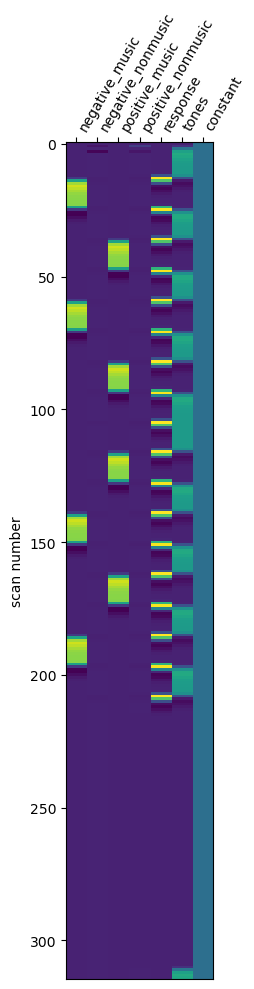

In [23]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

In [ ]:
# Create the dictionary of the conditions

conditions = {
    'active': np.array([1, 0, 0]), # Specify the np array, e.g. np.array([2, -1, 0]) to extract active
    'rest':np.array([0, 1, 0]) # Specify the np array, e.g. np.array([2, -1, 0]) to extract rest
}

active_minus_rest = conditions['active'] - conditions['rest']

In [ ]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(active_minus_rest, design_matrix=fmri_glm.design_matrices_[0])  ####TODO ADD COLOR SCALE

In [ ]:
import nibabel as nib
z_map = fmri_glm.compute_contrast(active_minus_rest,
                                  output_type='z_score')

nib.save(z_map, 'z_map_uncorrected.nii.gz')

In [ ]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(fmri_img),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=3.0,
              display_mode='z', cut_coords=[-3,37,70], black_bg=True,
              title='Active minus Rest (Z>3)')
plt.show()